In [1]:
%matplotlib inline

In [2]:
import os 
import sys

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/raul.sanchez/k/santander_product_recommendation


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

In [4]:
from src import config
from src.features import folds
from src.features.utils.features import PRODUCT_FEATURES, TOP_N

In [5]:
challengers = [
    'item_most_popular', 
    'user_most_popular', 
    'recsysnet', 
    'net_multilabel',
    'fact_matrix']

ndcg_all, ndcg, coldstart_ratio, coldstart_nb_users = [], [], {}, {}
for fold_id in folds.list():
    print(fold_id)
    train, test, _ = folds.get(fold_id)
    cold_star_users = set(test['ncodpers'].unique()) - set(train['ncodpers'].unique())
    is_cold_start = test.index.isin(cold_star_users)
    
    coldstart_ratio[test['fecha_dato'].min()] = is_cold_start.mean()
    coldstart_nb_users[test['fecha_dato'].min()] = is_cold_start.sum()
    
    fold_ndcg_all, fold_ndcg = {}, {}
    for challenger_name in challengers:
        print(challenger_name)
        scores = os.path.join(
            config.PRJ_DIR, 
            'data/processed/ranks/{0}/{1}.csv.gz'.format(
                challenger_name, 
                '{:02d}'.format(fold_id)))
        scores = pd.read_csv(scores)

        fold_ndcg_all[challenger_name] = ndcg_score(
            test.loc[is_cold_start][PRODUCT_FEATURES],
            scores.loc[is_cold_start][PRODUCT_FEATURES],
            k=TOP_N)

        fold_ndcg[challenger_name] = ndcg_score(
            test.loc[is_cold_start][PRODUCT_FEATURES].drop('ind_cco_fin_ult1', axis=1),
            scores.loc[is_cold_start][PRODUCT_FEATURES].drop('ind_cco_fin_ult1', axis=1),
            k=TOP_N)
    
    ndcg_all.append(fold_ndcg_all)
    ndcg.append(fold_ndcg)

coldstart_nb_users = pd.Series(coldstart_nb_users)
coldstart_ratio = pd.Series(coldstart_ratio)
ndcg_all_df = pd.DataFrame(ndcg_all, index=coldstart_ratio.index)
ndcg_df = pd.DataFrame(ndcg, index=coldstart_ratio.index)

1


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
2


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
3


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
4


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
5


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,13,16,17,24) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
6


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
7


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,13,16,17,24) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
8


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
9


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (11,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
10


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix
11


/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (11,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/raul.sanchez/anaconda3/envs/spyder/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


item_most_popular
user_most_popular
recsysnet
net_multilabel
fact_matrix


Text(0, 0.5, 'nb-users')

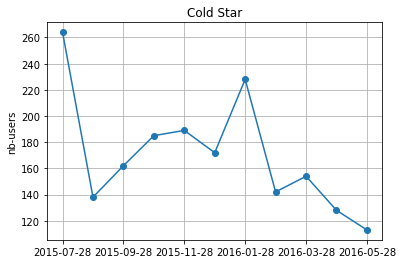

In [6]:
ax = coldstart_nb_users.plot(
    marker='o', 
    grid=True,
    title='Cold Star')

ax.set_ylabel('nb-users')

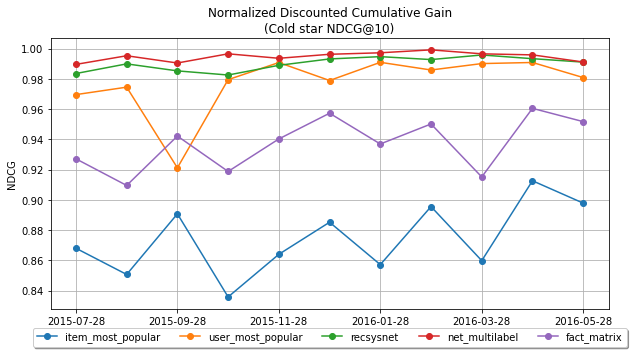

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ndcg_all_df.plot(
    marker='o',
    grid=True,
    ax=ax)

ax.set_title('Normalized Discounted Cumulative Gain\n(Cold star NDCG@10)')
ax.set_ylabel('NDCG')
ax.set_xlabel('Fold-id')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5);

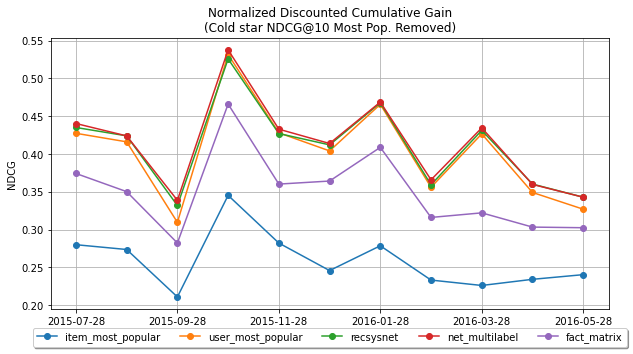

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ndcg_df.plot(
    marker='o',
    grid=True,
    ax=ax)

ax.set_title('Normalized Discounted Cumulative Gain\n(Cold star NDCG@10 Most Pop. Removed)')
ax.set_ylabel('NDCG')
ax.set_xlabel('Fold-id')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5);